<a href="https://colab.research.google.com/github/pycoyle/hello-world/blob/master/RiskRank_batch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -q --upgrade tensorflow==2.1
import numpy as np
import tensorflow.compat.v2   as tf
import tensorflow_probability as tfp


In [0]:
# Tab Trading System Populations

# Choose 32 of 64 but precision. 
dtype=tf.float64
#dtype=tf.float32

populationTitle = tf.constant(["Name","Type","Portfolio","Risk1-Rate",
                            "Risk1-Size","Risk2_Tot","Risk2_0m","Risk2_3m","Risk2_6m",
                            "Risk2_1y","Risk2_2y","Risk2_3y","Risk2_4y","Risk2_5y","Risk2_7y",
                            "Risk2_10y","Risk2_12y","Risk2_15y","Risk2_20y","Risk2_25y",
                            "Risk2_30y","Risk2_40y","Risk2_40+y"])

# ToDo - load this data from a file. 
np_population_values = np.array(
    [["Population1",	"Type1",	"State3",	1.5,	-1000000,	 -470,   	0,	0,	0,	 0,  0,	0,	  -141, -329,	0,	0,	   0,	0,	  0,	  0,	0,	0,	0],
     ["Population2",	"Type2",	"State4",	3.4,	-10000000, -3300,	  0,	0,	0,	 0,  0, -2310, -990, 0,	  0,	0,     0,	0,	  0,	  0,	0,	0,	0],
     ["Population3",	"Type3",	"State6",	2.6,	 5000000,	  8000,   0,	0,	0,	 0,  0,	0,	   0,	   0,	  0,	0,	   0,	6400,	1600,	0,	0,	0,	0],
     ["Population4",	"Type2",	"State7",	0.5,	-2500000,	 -250,    0,	0,	0, -250, 0,	0,	   0,	   0,	  0,	0,	   0,	0,	  0,	  0,	0,	0,	0],
     ["Population5",	"Type3",	"State1",	2.1,	-3000000,	 -3000,	  0,	0,	0, 	 0,  0,	0,	   0,	   0,	  0,	-3000, 0,	0,	  0,	  0,	0,	0,	0]])
#tf_popLabels=tf.constant(np_populationValues[:,:3])

# We will be using Type and State a lot to index into the tensors
# We therefore  represent  population, type, state as ints so we can use them
# later for slicing. 
tf_popLabels_int = tf.constant([[1,1,3],\
                                [2,2,4],
                                [3,3,6],
                                [4,2,7],
                                [5,3,1]],dtype=tf.int32)

# Take the nueric values from populations into a TF tensor 
tf_popVals=tf.constant(np_population_values[:,3:], dtype=dtype)



In [0]:
# Tab2 Probability Matrix
#Transition Probabilities
matrix=tf.constant([[[0.6,0.15,0.1,0.08,0.04,0.02,0.0075,0.0025],
                     [0.1,0.55,0.13,0.1,0.06,0.0325,0.015,0.0125],
                     [0.075,0.1325,0.52,0.12,0.07,0.04,0.025,0.0175],
                     [0.05,0.1,0.12,0.5,0.1,0.06,0.04,0.03],
                     [0.02,0.05,0.08,0.14,0.48,0.12,0.06,0.05],
                     [0.015,0.03,0.05,0.1,0.18,0.45,0.1,0.075],
                     [0.01,0.015,0.023,0.077,0.12,0.235,0.4,0.12]],
                   [[0.7,0.11,0.09,0.05,0.03,0.012,0.0065,0.0015],
                    [0.16,0.6,0.1,0.06,0.04,0.025,0.01,0.005],
                    [0.08,0.1,0.57,0.09,0.075,0.045,0.03,0.01],
                    [0.05,0.09,0.12,0.54,0.09,0.05,0.04,0.02],
                    [0.03,0.06,0.07,0.12,0.5,0.12,0.06,0.04],
                    [0.02,0.04,0.05,0.08,0.14,0.47,0.15,0.05],
                    [0.01,0.02,0.03,0.07,0.12,0.25,0.42,0.08]],
                   [[0.65,0.13,0.095,0.065,0.035,0.016,0.007,0.002],
                    [0.13,0.575,0.115,0.08,0.05,0.02875,0.0125,0.00875],
                    [0.0775,0.11625,0.545,0.105,0.0725,0.0425,0.0275,0.01375],
                    [0.05,0.095,0.12,0.52,0.095,0.055,0.04,0.025],
                    [0.025,0.055,0.075,0.13,0.49,0.12,0.06,0.045],
                    [0.0175,0.035,0.05,0.09,0.16,0.46,0.125,0.0625],
                    [0.01,0.0175,0.0265,0.0735,0.12,0.2425,0.41,0.1]]], dtype=dtype)

#Cumuilative Probabilities
cum_matrix = tf.math.cumsum(matrix, axis=2)


In [0]:

#tab3 - Correlation
type_corr=tf.constant([[0.6,0.3,0.1],
                       [0.3,0.7,0.2],
                       [0.1,0.2,0.5]], dtype=dtype)



In [1489]:
# The gathers below are to group the Type->type transition matrix
# to a population-population matrix, based on type. 
# [Q] I don't understand what this represents. 

# p_type is the type for each population. 
# This is used to index into the type-type matrix to get the value 
# and thus build up a population-population matrix
p_type= tf_popLabels_int [:,1]-1
x= tf.gather(type_corr, p_type)
y= tf.gather(x, p_type, axis=1)
diag=tf.linalg.tensor_diag(tf.linalg.diag_part(y))
I=tf.eye(p_type.numpy().size, dtype=dtype)
#print(p_type)
matrix = (y+I-diag)
print(matrix)


tf.Tensor(
[[1.  0.3 0.1 0.3 0.1]
 [0.3 1.  0.2 0.7 0.2]
 [0.1 0.2 1.  0.2 0.5]
 [0.3 0.7 0.2 1.  0.2]
 [0.1 0.2 0.5 0.2 1. ]], shape=(5, 5), dtype=float64)


In [1512]:
#Tab3 Cholesky Decom
chol1 = tf.linalg.cholesky(matrix)
chol2 = tf.transpose(chol1)

<tf.Tensor: shape=(5, 5), dtype=float64, numpy=
array([[1.        , 0.3       , 0.1       , 0.3       , 0.1       ],
       [0.        , 0.9539392 , 0.17820842, 0.63945375, 0.17820842],
       [0.        , 0.        , 0.97889824, 0.05725208, 0.46811991],
       [0.        , 0.        , 0.        , 0.70556438, 0.04144642],
       [0.        , 0.        , 0.        , 0.        , 0.85871282]])>

In [1491]:
#tab5 Scenario Shocks
shock_term=tf.constant([0,0.25,0.5,1,2,3,4,5,7,10,12,15,20,25,30,40,1024], dtype=dtype)

shocks=tf.constant([
          [[24,24,24,37,46,54,57,67,70,75,77,80,80,80,81,81,81],
          [68,68,68,80,94,105,112,123,127,131,133,136,137,139,140,140,140],
          [98,98,98,108,128,143,154,166,170,173,175,179,180,183,186,186,186],
          [174,174,174,190,216,236,251,263,263,264,265,268,269,272,274,274,274],
          [360,360,360,418,462,486,503,505,501,481,488,497,504,502,500,500,500],
          [571,571,571,671,732,760,781,772,763,724,735,751,763,757,750,750,750],
          [976,976,976,1165,1263,1299,1330,1301,1283,1206,1227,1258,1282,1266,1250,1250,1250]],

          [[3,3,3,7,11,14,18,22,26,32,32,33,38,40,41,41,41],
          [18,18,18,23,30,36,42,47,52,58,59,62,67,69,70,70,70],
          [49,49,49,56,67,76,83,90,95,100,103,108,112,115,117,117,117],
          [78,78,78,90,109,126,138,149,155,161,165,171,176,179,182,182,182],            
          [161,161,161,185,222,254,272,294,299,305,310,317,323,324,324,324,324],
          [420,420,420,470,567,624,652,673,659,646,649,653,655,653,652,652,652],
          [1052,1052,1052,1170,1291,1329,1337,1331,1254,1188,1182,1173,1169,1158,1148,1148,1148]],
  
          [[7,7,7,10,13,15,17,20,23,26,28,29,31,32,33,33,33],
          [32,32,32,38,46,53,60,66,71,77,79,82,88,90,91,91,91],
          [40,40,40,50,64,76,85,95,102,109,111,114,117,120,123,123,123],
          [104,104,104,124,159,184,203,221,234,247,251,257,262,264,266,266,266],
          [231,231,231,260,310,342,363,390,408,424,428,434,439,441,443,443,443],
          [378,378,378,414,479,519,542,577,600,621,625,630,636,638,640,640,640],
          [683,683,683,744,846,907,937,992,1025,1053,1057,1062,1067,1068,1069,1069,1069]]
          ], dtype=dtype)
tf.reduce_sum(shocks)

<tf.Tensor: shape=(), dtype=float64, numpy=128464.0>

In [0]:
# Pull out all the shocks for all states
key=tf_popLabels_int[:,1]-1
states=tf.constant(tf.range(shocks[1,:,1].shape[0]))
key=tf.expand_dims(key, axis=-1)*tf.ones(7,dtype=tf.int32)
states=tf.expand_dims(states, axis=-1)**tf.ones(5, dtype=tf.int32)
key = tf.transpose(tf.stack([key,tf.transpose(states)]))
a=tf.gather_nd(shocks,key)
# Pull out the shocks for the type/state of the population
key=tf_popLabels_int[:,1:]-1
b=tf.gather_nd(shocks,key)
#print(key)
#print(shocks.shape)
#print(b.shape)

#Diff the two
pl = a-b
#pl

In [0]:

# Tab4 PL Totals are tken from the positions
pl_totals  = tf_popVals[:,2]   
#pl_totals

In [0]:
#tab 4 P&L scaled 
scaled_pl = tf.transpose(tf.transpose(pl,perm=[0,2,1])*pl_totals,perm=[0,2,1])
#scaled_pl

In [0]:
#Tab4 Risk 2 Absolute Normalised
abs_norm=tf.transpose(tf.transpose(tf.abs(tf_popVals[:,3:]))/tf.abs(pl_totals))
#abs_norm

In [0]:
#Tab4 PL Vector
pl_vector = scaled_pl*abs_norm
#pl_vector

In [0]:
#Tab4 Total P&L
totalPL = tf.transpose(tf.reduce_sum(pl_vector,2))
#totalPL

In [0]:
trials  = 1000  #@param 
batches =     3 #@param
seed    =   7   #@param

In [0]:
#Tab6 (Scenario Vector) Scenario Vector
tfd = tfp.distributions
# We want to run a batch of simulations
#correlation=tf.transpose(tf.expand_dims(chol1,axis=-1)*tf.ones(batches, dtype=dtype),[2,0,1])
mvn = tfd.MultivariateNormalTriL(
    scale_tril=correlation)
### Single dim sim
#mvn = tfd.MultivariateNormalTriL(
#    scale_tril=chol1)

correlated_norms_sample = mvn.sample([trials], seed=seed, dtype=dtype)

#correlated_norms_sample
#correlation


In [1500]:
#Tab6 (Scenario Vector)- check the correlations using the TensorFlowProbability distribution
mvn.covariance().numpy()

array([[[1. , 0.3, 0.1, 0.3, 0.1],
        [0.3, 1. , 0.2, 0.7, 0.2],
        [0.1, 0.2, 1. , 0.2, 0.5],
        [0.3, 0.7, 0.2, 1. , 0.2],
        [0.1, 0.2, 0.5, 0.2, 1. ]],

       [[1. , 0.3, 0.1, 0.3, 0.1],
        [0.3, 1. , 0.2, 0.7, 0.2],
        [0.1, 0.2, 1. , 0.2, 0.5],
        [0.3, 0.7, 0.2, 1. , 0.2],
        [0.1, 0.2, 0.5, 0.2, 1. ]],

       [[1. , 0.3, 0.1, 0.3, 0.1],
        [0.3, 1. , 0.2, 0.7, 0.2],
        [0.1, 0.2, 1. , 0.2, 0.5],
        [0.3, 0.7, 0.2, 1. , 0.2],
        [0.1, 0.2, 0.5, 0.2, 1. ]]])

In [1501]:
#Tab6 (Scenario Vector) check the correlations of the sample generated
tfp.stats.correlation(
    correlated_norms_sample
)
ss=tfp.stats.correlation(correlated_norms_sample[:,:,:], sample_axis=0, event_axis=1)

ss.shape
tf.transpose(ss,[2,0,1])

<tf.Tensor: shape=(5, 3, 3), dtype=float64, numpy=
array([[[ 1.        ,  0.00478202, -0.00143199],
        [ 0.00478202,  1.        , -0.02358447],
        [-0.00143199, -0.02358447,  1.        ]],

       [[ 1.        , -0.04421539, -0.00192788],
        [-0.04421539,  1.        , -0.01624595],
        [-0.00192788, -0.01624595,  1.        ]],

       [[ 1.        ,  0.03663954, -0.05667938],
        [ 0.03663954,  1.        , -0.00910917],
        [-0.05667938, -0.00910917,  1.        ]],

       [[ 1.        , -0.01606421, -0.01797112],
        [-0.01606421,  1.        , -0.04713368],
        [-0.01797112, -0.04713368,  1.        ]],

       [[ 1.        ,  0.01372819, -0.05141339],
        [ 0.01372819,  1.        ,  0.01426402],
        [-0.05141339,  0.01426402,  1.        ]]])>

In [0]:
#Tab6 (Scenario Vector) convert normals to uniform

# First attent to convert gausian RV's to uniform via error function to create the CDF
#uniform_sample= (1. + tf.math.erf(correlated_norms_sample/1.41421356237))/2.0

# The tensorflow probability CDF is more elegent. 
norm=tfd.Normal(0,tf.constant(1., dtype=dtype))
uniform_sample=norm.cdf(correlated_norms_sample )


In [0]:
#Tab6 (Scenario Vector) Cumulative Probability Vector
# Slice the [type,state] for each population. 
key=tf_popLabels_int[:,1:]-1 
# Gather the entries from the cumulative_probability_matrix for the population [type,state]
# To generate the table for the population.

cum_prob_for_populations = tf.gather_nd(cum_matrix,key)
# We are running 'batch' simulations so duplicate this probability table 'batch' times. 
# The reordering of the axis is to align with future matrix multiplications. 
cum_prob_for_populations_batch = tf.transpose(tf.expand_dims(cum_prob_for_populations,axis=-1)*tf.ones(batches, dtype=dtype),[2,0,1])


In [1504]:
cum_prob_for_populations_batch.shape

TensorShape([3, 5, 8])

In [1505]:
uniform_sample.shape

TensorShape([1000, 3, 5])

In [1506]:
#Tab6 (Scenario Vector) Convert uniform normals into a 'state' based on the cumulative probabilities per population. 

index=tf.searchsorted(cum_prob_for_populations_batch ,tf.transpose(uniform_sample) , side='left', out_type=tf.dtypes.int32, name=None)
index.shape

TensorShape([5, 3, 1000])

In [1507]:
# (Not in spreadsheet)
# Check the distribution of states for the first population in the first batch. 
x,y,c = tf.unique_with_counts(index[0,0,:], out_idx=tf.dtypes.int32, name=None)
print(x)
print(c/trials)


tf.Tensor([2 0 3 4 5 6 1 7], shape=(8,), dtype=int32)
tf.Tensor([0.506 0.083 0.123 0.074 0.037 0.026 0.135 0.016], shape=(8,), dtype=float64)


In [0]:
# The final tate of the PL table is taken from the population input using the formula
# Portfolio_size * (1-Risk1_rate)
default_state = tf.multiply(tf_popVals[:,1],(1.0-tf_popVals[:,0]))

# The generated PL table does not include the final state ( default?)
# Which is is taken from the input populations ( Risk2_Tot)
#A dd State8 (default?) to the PL table. 
# To add the vector to the table, first I exand the dimensions of the vector
# so it has the same dimensions as the table. 
# Then I can concatenate the vector as an extra colum at the end of the table. 
pl_table = tf.concat([totalPL,tf.expand_dims(default_state,-1)], axis=1)

# We are running a batch of 'batch' simulations so expand the table to a 3d tensor
# We expand the dimensions again and then multiply by a vector of ones to generate 
# 'batch' copies of the table. Then Swich round the dimensions to make the following
# matrix multiplications easier. 
pl_table_batch =tf.transpose(tf.expand_dims(pl_table,axis=-1)*tf.ones(batches, dtype=dtype),[0,2,1])


In [0]:

# This like took a while to figure out - but it's obvious now - Doh!
# We now have the table of PL's for each state for each population(
# with three copies, one for each batch: 'pl_table_batch' [5(populations),3(batches),8(states)]
# We also have 'index' the uniform normals transormed into 'states' by mapping each number to 
# the cumulative probability for each state. This has dimensions [5(populations), 3(batches), 1m(scenarios)]
# The following line uses the innermost dimension of 'index' - the scenarios to lookup, for eah scenario, 
# the corresponding PL value from the table of states - matched on population and batch ( the two batch dimensions)

 
pl_output=tf.gather(pl_table_batch,
                 index,
                 batch_dims=2)


In [1510]:
#Tab 9 (Total Ranking)

# Collapse the batch dimension to sum the PL's per batch
# [Q - Why sum over batches here? Should this be an average?]
# Sum over batches & populations
riskValue = tf.reduce_sum(pl_output,[0,1])
# sum over populations
ranked_risk = tf.sort(riskValue,axis=-1,direction='ASCENDING',name=None)
# 99th Percent worst
percentile99=int(trials*(100.-99.)/100.-1.0) # count from 0 to 99
print("index=",(percentile99))
print("99th Percentile",ranked_risk[percentile99].numpy())
print(ranked_risk[percentile99-1].numpy())
print(ranked_risk[percentile99-2].numpy())
print(ranked_risk[percentile99-3].numpy())
print(ranked_risk[percentile99-4].numpy())
print(ranked_risk[percentile99-5].numpy())
print(ranked_risk[percentile99-6].numpy())
print(ranked_risk[percentile99-7].numpy())
print(ranked_risk[percentile99-8].numpy())
print(ranked_risk[percentile99-9].numpy())
print("center")
print(ranked_risk[percentile99+1].numpy())
print(ranked_risk[percentile99+2].numpy())
print(ranked_risk[percentile99+3].numpy())
print(ranked_risk[percentile99+4].numpy())
print(ranked_risk[percentile99+5].numpy())
print(ranked_risk[percentile99+6].numpy())
print(ranked_risk[percentile99+7].numpy())
print(ranked_risk[percentile99+8].numpy())
print(ranked_risk[percentile99+9].numpy())
ranked_risk.shape

index= 9
99th Percentile -22538341.0
-22550301.0
-22795910.0
-23686281.0
-23971091.0
-24223521.0
-24274150.0
-27934231.0
-28960641.0
-34208422.0
center
-22110641.0
-21986031.0
-21679212.0
-21602681.0
-21600761.0
-21444161.0
-21352731.0
-21344282.0
-21195651.0


TensorShape([1000])

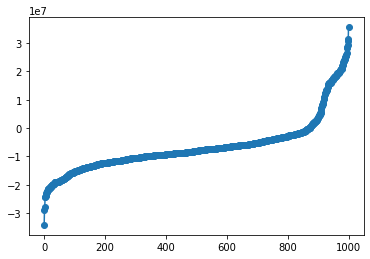

In [1511]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(ranked_risk,marker='o')